In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import geemap, ee

import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [4]:
%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../lib/')


In [5]:
%reload_ext autoreload
import sand_classification as sc
import quality_mosaic as qm
import train_val as tv

# Train Classifier

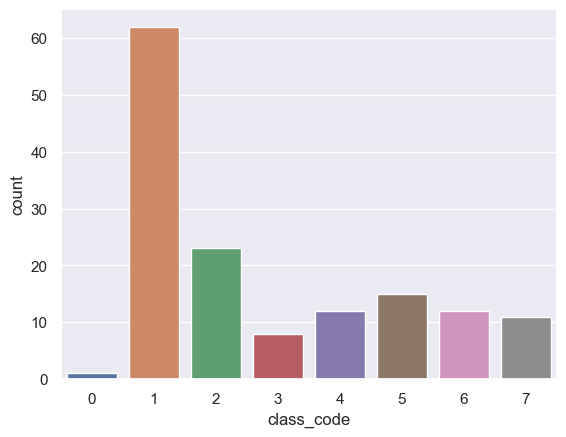

In [6]:
RF, _ = tv.train_rf('../data/labels/gt-bands.xlsx', num_trees=400)

#### Load Image for Validation

In [7]:
roi = ee.FeatureCollection('projects/gee-sand/assets/gandak_gst_aoi')
upper = ee.FeatureCollection('projects/gee-sand/assets/gandak_gst_upper_aoi')
lower = ee.FeatureCollection('projects/gee-sand/assets/gandak_gst_lower_aoi')

# roi = upper.union({'right': lower})

In [8]:
date = '2022-02-15' #from analysis in river_sand_flooding_gst GEE 
max_search_window_months = 2
median_samples = 5
mosaic_method = 'median'

lon, lat = 83.85196876107901, 27.346501623680787
gandak_gst = ee.Geometry.Point([lon, lat])

mining_centroids = ee.FeatureCollection('projects/gee-sand/assets/bihar_sand_banks_centroids')

s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()
roi

Search window from 2021-12-15 to 2022-04-15


#### SNIC

In [9]:
snicBands = tv.apply_snic(image=s1_s2, roi=roi)

In [10]:
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.add_basemap('SATELLITE')
# Map.add_basemap('Stamen.Toner')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI', False)
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')


Map

Map(center=[27.110156013724573, 84.12375736993856], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
classy_RF = snicBands.classify(RF)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# classy_RF.getInfo()

Map.addLayer(
    classy_RF,
    {"min": 0, "max": len(qm.class_dict)-1, "palette": tv.palette},
    'classification',
)

Map.add_legend(title="Classes", legend_dict=qm.legend_dict, position="bottomleft")


In [13]:
RF_prob = RF.setOutputMode('MULTIPROBABILITY')

classy_RF_multi = snicBands.classify(RF_prob)
# classy_RF_multi = classy_RF_multi.reproject (crs = classy_RF_multi.projection (), scale = 10)


classNameList = list(tv.legend_dict.keys())
rfresult_PROB = classy_RF_multi.arrayFlatten([classNameList])

In [14]:
thresholds = [0, 0.3, 0.1, 0, 0.2, 0, 0, 0]
keys = list(tv.legend_dict.keys())

for i, t in enumerate(thresholds):
    if t == 0:
        continue

    Map.addLayer(
        rfresult_PROB.select(i).gt(t),
        {"min": 0, "max": 1, "palette": ["black", tv.legend_dict[keys[i]]]},
        f"classification_{keys[i]}",
    )

## Masks

In [27]:
mask_sand = classy_RF.remap([0,2,3,4,5,6,7], [0,2,3,4,5,6,7])
mask_gravel = classy_RF.remap([0,1,3,4,5,6,7], [0,1,3,4,5,6,7])

Map.addLayer(mask_sand, {"palette": 'black'},
             '[mask]Sand');
Map.addLayer(mask_gravel, {"palette": 'black'},
             '[mask]Gravel');

In [29]:
classy_RF

### Add zones and mining locations to map

In [15]:
#Create the outline of the upper section
empty = ee.Image().byte()
outline = empty.paint(featureCollection = upper,
  color= 1,
  width= 3)
Map.addLayer(outline, {'palette': 'a2a2d0'}, 'GST Upriver')

#Create the outline of the lower section
empty = ee.Image().byte()
outline = empty.paint(featureCollection = lower,
  color= 1,
  width= 3)
Map.addLayer(outline, {'palette': 'cc00ff'}, 'GST Downriver')

Map.addLayer(gandak_gst, {'color':'red', 'size':20},'GST')

Map.addLayer(mining_centroids, {'color':'blue'}, 'Mining Centroids')

In [ ]:
#Create the outline of the upper section
empty = ee.Image().byte()
outline = empty.paint(featureCollection = upper,
  color= 1,
  width= 3)
Map.addLayer(outline, {'palette': 'a2a2d0'}, 'GST Upriver')

#Create the outline of the lower section
empty = ee.Image().byte()
outline = empty.paint(featureCollection = lower,
  color= 1,
  width= 3)
Map.addLayer(outline, {'palette': 'cc00ff'}, 'GST Downriver')

Map.addLayer(gandak_gst, {'color':'red', 'size':20},'GST')

Map.addLayer(mining_centroids, {'color':'blue'}, 'Mining Centroids')

## Statistics

A. For classification outputs

In [34]:
sand_only = classy_RF.eq(1)
sand_only_count_upper = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_upper = sand_only_count_upper.getInfo()['classification']

gravel_only = classy_RF.eq(2)
gravel_only_count_upper = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)
gravel_only_count_upper = gravel_only_count_upper.getInfo()['classification']
s_to_g_ratio_upper = sand_only_count_upper/gravel_only_count_upper
s_to_g_ratio_upper

1.8647083972821188

In [35]:
sand_only_count_lower = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

gravel_only_count_lower = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_lower   = sand_only_count_lower.getInfo()['classification']
gravel_only_count_lower = gravel_only_count_lower.getInfo()['classification']

s_to_g_ratio_lower = sand_only_count_lower/gravel_only_count_lower

print(s_to_g_ratio_upper,s_to_g_ratio_lower)

1.8647083972821188 1.8960068815155298


B. For thresholded classification outputs

In [18]:
# count the number of pixels in sand_only that have a value of 1 within upper and lower

sand_only = rfresult_PROB.select(1).gt(0.25)
sand_only_count_upper = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_upper = sand_only_count_upper.getInfo()['sand']

gravel_only = rfresult_PROB.select(2).gt(0.25)
gravel_only_count_upper = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=upper,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)
gravel_only_count_upper = gravel_only_count_upper.getInfo()['gravel']
s_to_g_ratio_upper = sand_only_count_upper/gravel_only_count_upper
s_to_g_ratio_upper


{'sand': 243301.96078431373}

In [ ]:
sand_only_count_lower = sand_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

gravel_only_count_lower = gravel_only.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=lower,
    scale=10,
    maxPixels=1e9,
    tileScale=10,
)

sand_only_count_lower   = sand_only_count_lower.getInfo()['sand']
gravel_only_count_lower = gravel_only_count_lower.getInfo()['gravel']

s_to_g_ratio_lower = sand_only_count_lower/gravel_only_count_lower

print(s_to_g_ratio_upper,s_to_g_ratio_lower)

6.872043006703238 5.306539826922616
